In [ ]:
# -------------------------
# import
# -------------------------

In [654]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# -------------------------
# config
# -------------------------

In [655]:
SEED = 42
DATA_PATH = "inputs/rheed_stoich_data.npz"
TRAIN_FRAC = 0.8
BATCH_SIZE = 4
DOWNSAMPLE_FACTOR = 1  # 540x720 -> 135x180
model = None

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
# -------------------------
# load data
# -------------------------

In [656]:
data = np.load(DATA_PATH)
stoich = data["stoich"].astype(np.float32).reshape(-1, 1)  # (N,1)
min_stoich, max_stoich = stoich.min(), stoich.max()
stoich = (stoich - min_stoich) / (max_stoich - min_stoich + 1e-8)
images = data["images"].astype(np.float32)                 # (N,H,W)
min_image, max_image = images.min(), images.max()
images = (images - min_image) / (max_image - min_image + 1e-8)

N, H, W = images.shape
IMG_HW = (H // DOWNSAMPLE_FACTOR, W // DOWNSAMPLE_FACTOR)

print("Loaded:", stoich.shape, images.shape, "-> downsampled to", IMG_HW)

Loaded: (31, 1) (31, 540, 720) -> downsampled to (540, 720)


In [ ]:
# -------------------------
# dataset
# -------------------------

In [ ]:
class PairedDataset(Dataset):
    def __init__(self, images_np, stoich_np, indices, img_hw, augment=False):
        self.images = images_np
        self.stoich = stoich_np
        self.indices = np.array(indices, dtype=int)
        self.img_hw = img_hw
        self.augment = augment

    def __len__(self):
        return len(self.indices)        

    def __getitem__(self, i):
        idx = self.indices[i]
        img = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        # downsample
        img = F.interpolate(img.unsqueeze(0), size=self.img_hw, mode="bilinear", align_corners=False).squeeze(0)
        sto = torch.tensor(self.stoich[idx], dtype=torch.float32)               # (1,)

        if self.augment:
            sto = sto + 0.0001 * torch.abs(sto).clamp_min(1e-6) * torch.randn_like(sto)
        return img, sto

In [ ]:
# -------------------------
# dataloader
# -------------------------

In [641]:
all_idx = np.arange(N)
train_idx, test_idx = train_test_split(all_idx, train_size=TRAIN_FRAC, random_state=SEED, shuffle=True)

train_ds = PairedDataset(images, stoich, train_idx, IMG_HW, augment=False)
test_ds  = PairedDataset(images, stoich, test_idx, IMG_HW, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [657]:
print(len(all_idx), len(train_idx), len(test_idx), len(train_ds), len(test_ds), len(train_loader), len(test_loader))

31 24 7 24 7 6 2


In [ ]:
# -------------------------
# model
# -------------------------

In [ ]:
LATENT1 = 48
LATENT2 = 12

class EncSto(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 2), nn.ReLU(),
            nn.Linear(2, LATENT1)
        )

    def forward(self, s):
        return self.net(s)                             # (B,32)

class DecSto(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT1, 2), nn.ReLU(),
            nn.Linear(2, 1)
        )

    def forward(self, z):
        return self.net(z)                               # (B,1)

class EncShared(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT1, 24), nn.ReLU(),
            nn.Linear(24, LATENT2)
        )

    def forward(self, z):
        return self.net(z)                             # (B,3)

class DecShared(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT2, 24), nn.ReLU(),
            nn.Linear(24, LATENT1)
        )

    def forward(self, z):
        return self.net(z)                             # (B,32)

class EncImg(nn.Module):
    def __init__(self, img_hw):
        super().__init__()
        self.img_hw = img_hw

        self.net = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1), nn.ReLU(),   # H/2, W/2
            nn.Conv2d(4, 16, 3, stride=2, padding=1), nn.ReLU(), # H/4, W/4
            nn.Conv2d(16, 64, 3, stride=2, padding=1), nn.ReLU() # H/8, W/8
        )

        # compute feature-map size dynamically
        h, w = img_hw
        h = (h + 7) // 8   # equivalent to ceil(h / 8)
        w = (w + 7) // 8

        self.fc = nn.Sequential(
            nn.Linear(64 * h * w, 64), nn.ReLU(),
            nn.Linear(64, LATENT1)
        )

    def forward(self, x):
        x = self.net(x)
        x = x.flatten(1)
        return self.fc(x)
        
class DecImg(nn.Module):
    def __init__(self, img_hw):
        super().__init__()
        self.img_hw = img_hw

        # encoder downsamples by factor 8
        start_h = int(np.ceil(img_hw[0] / 8))
        start_w = int(np.ceil(img_hw[1] / 8))
        self.start_h, self.start_w = start_h, start_w

        # latent → feature map (match encoder channels = 8)
        self.fc = nn.Sequential(
            nn.Linear(LATENT1, 64), nn.ReLU(),
            nn.Linear(64, 64 * start_h * start_w), nn.ReLU(),        
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 4, stride=2, padding=1), nn.ReLU(),  # ×2
            nn.ConvTranspose2d(16, 4, 4, stride=2, padding=1), nn.ReLU(),  # ×4
            nn.ConvTranspose2d(4, 1, 4, stride=2, padding=1),              # ×8
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 64, self.start_h, self.start_w)
        x = self.net(x)
        return x[:, :, :self.img_hw[0], :self.img_hw[1]]

class UniversalTranslator(nn.Module):
    def __init__(self, img_hw):
        super().__init__()
        self.enc_img = EncImg(img_hw)
        self.enc_sto = EncSto()
        self.enc_shared = EncShared()
        self.dec_shared = DecShared()
        self.dec_img = DecImg(img_hw)
        self.dec_sto = DecSto()

    def forward(self, img, sto):
        # -------- image path --------
        z_img1 = self.enc_img(img)
        z_img2  = self.enc_shared(z_img1)
        z_img2b = self.dec_shared(z_img2)

        img_i2i = self.dec_img(z_img2b)
        sto_i2s = self.dec_sto(z_img2b)

        # -------- stoich path --------
        z_sto1 = self.enc_sto(sto)
        z_sto2  = self.enc_shared(z_sto1)
        z_sto2b = self.dec_shared(z_sto2)

        img_s2i = self.dec_img(z_sto2b)
        sto_s2s = self.dec_sto(z_sto2b)

        return {
            "img_i2i": img_i2i,
            "sto_i2s": sto_i2s,
            "img_s2i": img_s2i,
            "sto_s2s": sto_s2s,
            "z_img2": z_img2,
            "z_sto2": z_sto2,
        }

In [ ]:
# -------------------------
# train
# -------------------------

In [ ]:
EPOCHS = 500
LR = 5e-4
model=None ## comment this out if using a saved/pretrained model, code for loading pretrained model can be found later
if model is None:
    model = UniversalTranslator(IMG_HW).to(device)
model.train()
opt = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in range(1, EPOCHS + 1):
    total = 0.0
    total_i2i = 0.0
    total_i2s = 0.0
    total_s2i = 0.0
    total_s2s = 0.0
    total_la = 0.0
    
    for img, sto in train_loader:
        img = img.to(device)   # (B,1,H,W)
        sto = sto.to(device)   # (B,1)

        out = model(img, sto)

        loss_i2i = F.mse_loss(out["img_i2i"], img)
        loss_i2s = F.mse_loss(out["sto_i2s"], sto)
        loss_s2i = F.mse_loss(out["img_s2i"], img)
        loss_s2s = F.mse_loss(out["sto_s2s"], sto)
        loss_la = F.mse_loss(out["z_img2"], out["z_sto2"])
        
        loss = 0.0
        loss += 1 * loss_i2i
        loss += 0.1 * loss_i2s
        loss += 10 * loss_s2i
        loss += 0.01 * loss_s2s
        loss += 0.001 * loss_la

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()
        total_i2i += loss_i2i.item()
        total_i2s += loss_i2s.item()
        total_s2i += loss_s2i.item()
        total_s2s += loss_s2s.item()
        total_la += loss_la.item()

    if epoch % int(EPOCHS/10) == 0 or epoch == 1:
        n = len(train_loader)
        print(
            f"Epoch {epoch:04d} | "
            f"total {total/n:.4f} | "
            f"i2i {total_i2i/n:.4f} | "
            f"i2s {total_i2s/n:.4f} | "
            f"s2i {total_s2i/n:.4f} | "
            f"s2s {total_s2s/n:.4f} | "
            f"latent {total_la/n:.4f}"
        )

In [704]:
# -------------------------
# saving model
# -------------------------

In [705]:
# torch.save(model.state_dict(), "outputs/model_weights.pth")

# np.savez(
#     "outputs/model_meta.npz",
#     min_stoich=min_stoich,
#     max_stoich=max_stoich,
#     min_image=min_image,
#     max_image=max_image,
#     IMG_HW=np.array(IMG_HW)
# )

# print("Model and metadata saved.")

In [706]:
# -------------------------
# loading previously saved model
# -------------------------

In [707]:
# model = UniversalTranslator(IMG_HW).to(device)
# model.load_state_dict(torch.load("outputs/model_weights.pth", map_location=device))
# model.eval()   # important for inference

In [708]:
# -------------------------
# evaluation
# -------------------------

In [701]:
@torch.no_grad()
def predict_from_input(
    model,
    input_data,
    input_type,        # "img" or "sto"
    IMG_HW,
    min_stoich, max_stoich,
    min_image, max_image,
    device="cpu"
):
    """
    input_data:
        - if img: raw image (H,W) from data["images"][i]
        - if sto: raw stoich scalar from data["stoich"][i]
    """

    model.eval()
    if input_type == "img":
        # ---- normalize image ----
        img = input_data.astype(np.float32)
        img = (img - min_image) / (max_image - min_image + 1e-8)

        img = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
        img = F.interpolate(img, IMG_HW, mode="bilinear", align_corners=False)
        img = img.to(device)

        # dummy sto (not used for encoding)
        sto = torch.zeros((1,1), device=device)

        out = model(img, sto)

        pred_img = out["img_i2i"]
        pred_sto = out["sto_i2s"]

    elif input_type == "sto":
        # ---- normalize stoich ----
        sto = np.array([[input_data]], dtype=np.float32)
        sto = (sto - min_stoich) / (max_stoich - min_stoich + 1e-8)
        sto = torch.tensor(sto).to(device)

        # dummy image (not used for encoding)
        img = torch.zeros((1,1,IMG_HW[0], IMG_HW[1]), device=device)

        out = model(img, sto)

        pred_img = out["img_s2i"]
        pred_sto = out["sto_s2s"]

    else:
        raise ValueError("input_type must be 'img' or 'sto'")

    # ---- denormalize outputs ----
    pred_img = pred_img.cpu().squeeze().numpy()
    pred_img = pred_img * (max_image - min_image) + min_image

    pred_sto = pred_sto.cpu().item()
    pred_sto = pred_sto * (max_stoich - min_stoich) + min_stoich

    return pred_img, pred_sto

True stoich: 61.0268 | Predicted stoich: 59.2195


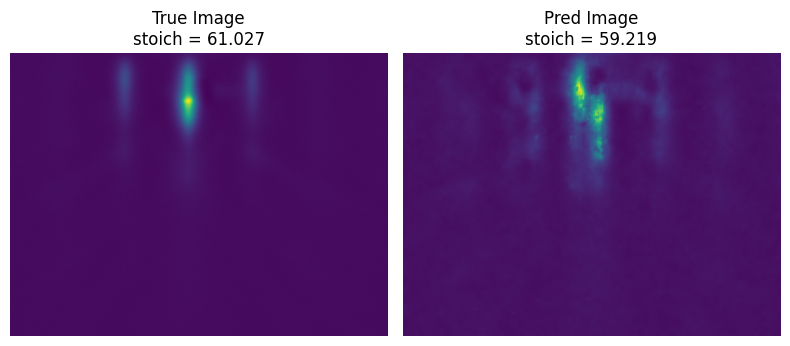

True stoich: 37.1403 | Predicted stoich: 36.8600


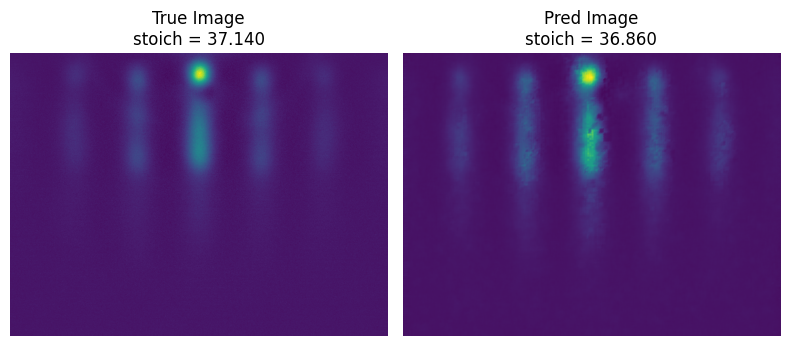

True stoich: 56.1305 | Predicted stoich: 55.5875


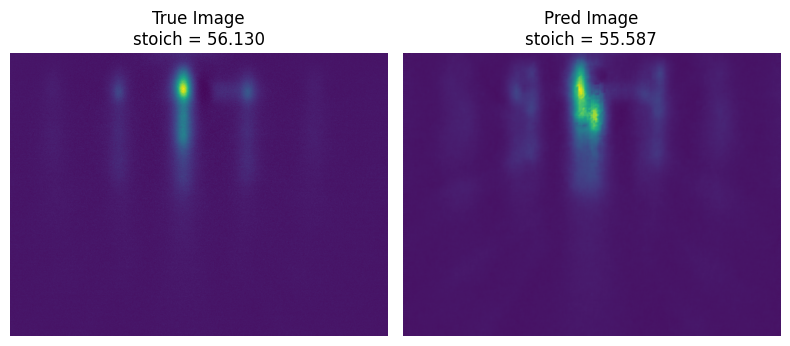

True stoich: 37.0899 | Predicted stoich: 36.8165


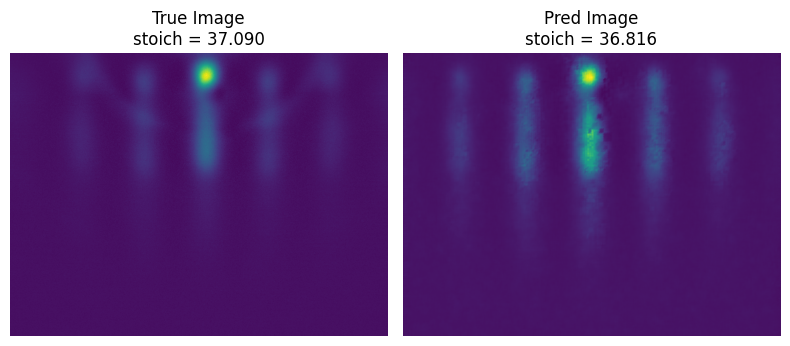

True stoich: 39.8031 | Predicted stoich: 39.7058


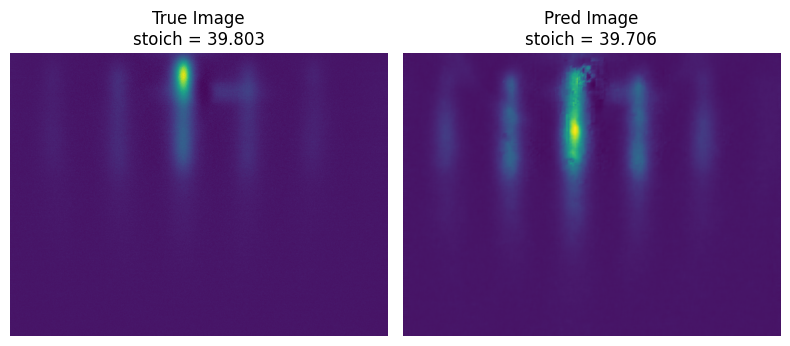

True stoich: 40.6744 | Predicted stoich: 40.9388


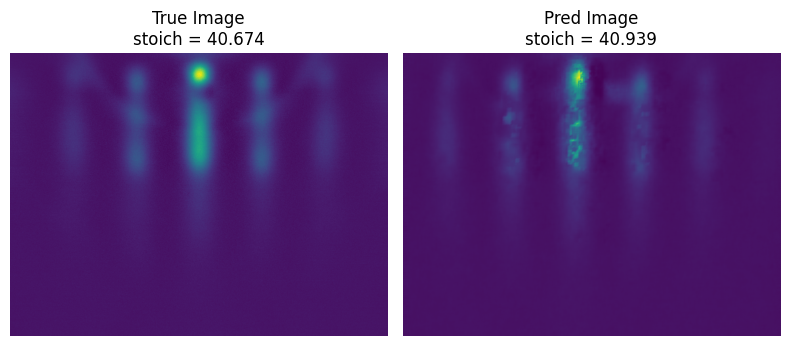

True stoich: 68.9981 | Predicted stoich: 69.2958


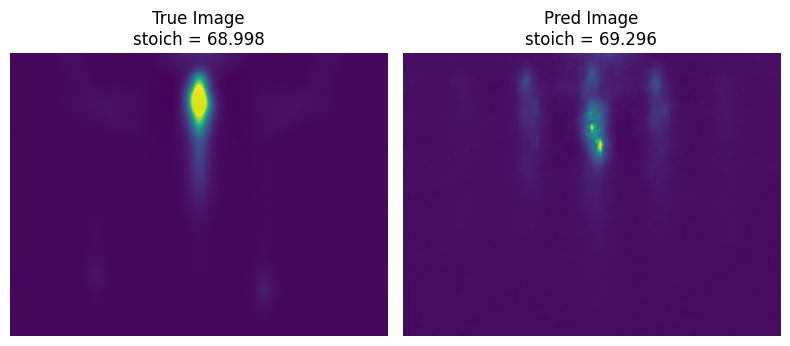

In [703]:
for i in test_idx:

    # ---- Ground truth ----
    true_img = data["images"][i]
    true_sto = float(data["stoich"][i])

    # ---- Prediction from image ----
    img_pred, sto_pred = predict_from_input(
        model=model,
        input_data=true_sto,
        input_type="sto",
        IMG_HW=IMG_HW,
        min_stoich=min_stoich,
        max_stoich=max_stoich,
        min_image=min_image,
        max_image=max_image,
        device=device
    )

    print(f"True stoich: {true_sto:.4f} | Predicted stoich: {sto_pred:.4f}")

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(true_img, cmap="viridis")
    axes[0].set_title(f"True Image\nstoich = {true_sto:.3f}")
    axes[0].axis("off")

    axes[1].imshow(img_pred, cmap="viridis")
    axes[1].set_title(f"Pred Image\nstoich = {sto_pred:.3f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()